In [1]:
library(reticulate)
library(ggplot2)
library(reshape2)
library(dplyr)
use_python("/usr/bin/python3")

git_repo_loc=Sys.getenv("GIT_REPO_LOC")
`%_%` <- function(x, y) { paste(x, y, sep="")}

py_run_string("import sys")
py_run_string("import pickle")
for (py_lib in c("LinearResponseVariationalBayes.py",
                 "BNP_sensitivity/GMM_clustering/",
                 "autograd")) {
    py_run_string("sys.path.append('" %_% file.path(git_repo_loc, py_lib) %_% "')")
}
py_run_string("
import os

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
from copy import deepcopy

import numpy as np
import scipy as sp
import json 

git_repo = os.environ['GIT_REPO_LOC']
")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
py_run_string("
# Load results from previous fit.
#filename = 'ryan_iris_bnp_full_data_fit_alpha2.0.json'
filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
#filename = 'ryan_simulation_bnp_full_data_fit_alpha8.0.json'
json_input_file = os.path.join(
    git_repo,
   'BNP_sensitivity/GMM_clustering/iris_fits/',
   filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

moment_model = gmm_utils.InterestingMoments(model)
")

py_main <- reticulate::import_main()
base_alpha <- py_main$model$prior_params['alpha']$get()

In [3]:
py_run_string("
linear_sensitivity = \\
    obj_lib.ParametricSensitivity(
        objective_fun =             model.set_z_get_kl,
        input_par =                 model.global_vb_params,
        output_par =                moment_model.moment_params,
        hyper_par =                 model.prior_params,
        input_to_output_converter = moment_model.set_moments,
        optimal_input_par =         best_param,
        objective_hessian =         kl_hessian)
")

In [4]:
py_run_string("
print(model.prior_params)

def refit_with_alpha(new_alpha, model, linear_sens):
    model.prior_params['alpha'].set(new_alpha)
    model.objective.logger.initialize()
    model.objective.logger.print_every = 10
    free_par_refit = \\
        linear_sensitivity.predict_input_par_from_hyperparameters(
            model.prior_params.get_vector())
    model.optimize_full(free_par_refit, bfgs_init=False)
    return free_par_refit, model.global_vb_params.get_free()
")

In [5]:
py_run_string("
alpha_vec = np.linspace(1, 14, num=10)

print(alpha_vec)
free_par_refit_list = []
free_par_refit_lr_list = []
for alpha in alpha_vec:
    print(alpha)
    free_par_refit_lr, free_par_refit = \\
        refit_with_alpha(alpha, model, linear_sensitivity)
    free_par_refit_list.append(free_par_refit)
    free_par_refit_lr_list.append(free_par_refit_lr)
")

In [6]:
GetResultDataFrame <- function(free_par, this_alpha, this_method) {
    py_main$moment_model$set_moments_from_free_par(free_par)
    centroids <- py_main$moment_model$moment_params['centroids']$get()
    cluster_weights <- py_main$moment_model$moment_params['cluster_weights']$get()

    centroid_df <- melt(centroids) %>%
        rename(dim=Var1, k=Var2) %>%
        mutate(alpha=this_alpha, method=this_method, variable="centroid")

    weight_df <- data.frame(value=cluster_weights) %>%
        mutate(dim=-1, k=1:length(cluster_weights)) %>%
        mutate(alpha=this_alpha, method=this_method, variable="cluster_weight")

    return(rbind(weight_df, centroid_df))
}


df_list <- list()

for (i in 1:length(py_main$alpha_vec)) {
    df_list[[length(df_list) + 1]]  <-
        rbind(
            GetResultDataFrame(
                py_main$free_par_refit_list[[i]],
                py_main$alpha_vec[i],
                'truth'),
            GetResultDataFrame(
                py_main$free_par_refit_lr_list[[i]],
                py_main$alpha_vec[i],
                'lr')
        )
}
df <- do.call(rbind, df_list)
head(df)

value,dim,k,alpha,method,variable
0.009068297,-1,1,1,truth,cluster_weight
0.074391740,-1,2,1,truth,cluster_weight
0.011091784,-1,3,1,truth,cluster_weight
0.014531065,-1,4,1,truth,cluster_weight
0.302368068,-1,5,1,truth,cluster_weight
0.322731242,-1,6,1,truth,cluster_weight


In [10]:
big_k <- filter(df, variable == "cluster_weight", method == "truth") %>%
    ungroup() %>% group_by(k) %>%
    summarize(max_weight=max(value)) %>%
    filter(max_weight > 0.01) %>%
    `[[`('k')
print(big_k)

[1]  2  3  4  5  6  7  9 10 12


In [11]:
df_cast <- dcast(df, alpha + dim + k + variable ~ method, value.var="value")
head(df_cast)
# ggplot(df_cast) +
#     geom_histogram(aes(x=lr - truth), bins=50)
# ggplot(df_cast) +
#     geom_line(aes(x=alpha, y=value, color=paste(dim, k))) +
#     facet_grid(dim ~ method, scales="free")

alpha,dim,k,variable,lr,truth
1,-1,1,cluster_weight,0.009046373,0.009068297
1,-1,2,cluster_weight,0.073807359,0.074391740
1,-1,3,cluster_weight,0.010994997,0.011091784
1,-1,4,cluster_weight,0.013121944,0.014531065
1,-1,5,cluster_weight,0.300296037,0.302368068
1,-1,6,cluster_weight,0.320844880,0.322731242


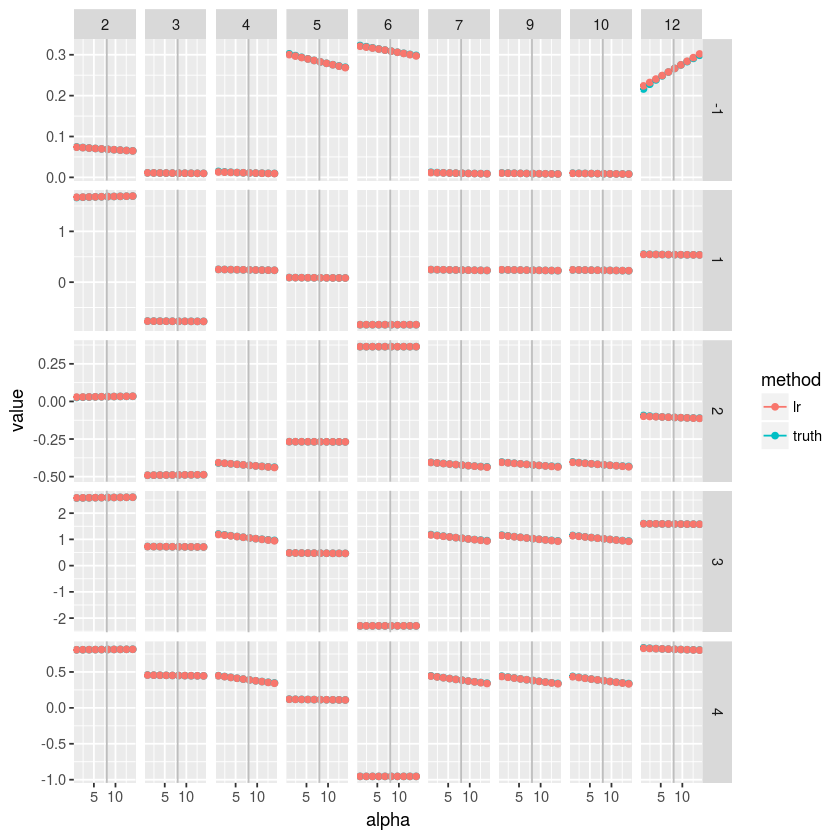

In [12]:
ggplot(filter(df, k %in% big_k)) +
    geom_line(aes(x=alpha, y=value, color=method)) +
    geom_point(aes(x=alpha, y=value, color=method)) +
    geom_vline(aes(xintercept=base_alpha), color="gray") +
    facet_grid(dim ~ k, scales="free")